In [297]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from enum import Enum

# Basics of Python data handling and visualization
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm import tqdm_notebook as tqdm

# Machine learning 
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import sklearn.pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam,geo_utils
from pyproj import Proj, transform

Dimension of the area is 249870 x 171656 m2


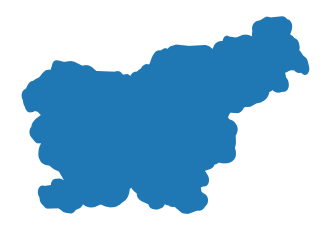

In [298]:
# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join('..', '..', 'D:\ISRO')

# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, 'temp.geojson'))

# Convert CRS to UTM_33N
country_crs = CRS.UTM_33N
country = country.to_crs(crs={'init': CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values.tolist()[-1]

# Plot country
country.plot()
plt.axis('off');

# Print size 
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],
                                                             country_shape.bounds[3] - country_shape.bounds[1]))

In [299]:
use_smaller_patches = True

# Create the splitter to obtain a list of bboxes
bbox_splitter_large = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_splitter_small = BBoxSplitter([country_shape], country_crs, (25 * 3, 17 * 3))

bbox_splitter = bbox_splitter_small if use_smaller_patches else bbox_splitter_large

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# For the future examples, we will be using a specific set of patches,
# but you are free to change the patch ID numbers in the scope of this example
# Select a central patch
ID = 1549 if use_smaller_patches else 190 

# Obtain surrounding patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 9:
    print('Warning! Use a different central patch ID, this one is on the border.')
    
# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()
    
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]

gdf = gpd.GeoDataFrame({'index_x': idxs_x, 'index_y': idxs_y}, 
                       crs={'init': CRS.ogc_string(country_crs)}, 
                       geometry=geometry)

# save to shapefile
shapefile_name = './selected_3x3_bboxes_slovenia_small.shp' if use_smaller_patches \
    else './selected_3x3_bboxes_slovenia_large.shp'
gdf.to_file(shapefile_name)

In [300]:
poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

# content of the geopandas dataframe
gdf.head()

index_x  index_y                                           geometry
0       42       29  POLYGON ((510157.6172221425 5122327.229129893,...
1       43       29  POLYGON ((513489.214628833 5122327.229129893, ...
2       44       29  POLYGON ((516820.8120355235 5122327.229129893,...
3       42       28  POLYGON ((510157.6172221425 5118961.421479214,...
4       43       28  POLYGON ((513489.214628833 5118961.421479214, ...

(357737.03586605104, 632593.8219180192, 5016135.9977509845, 5204957.80695405)

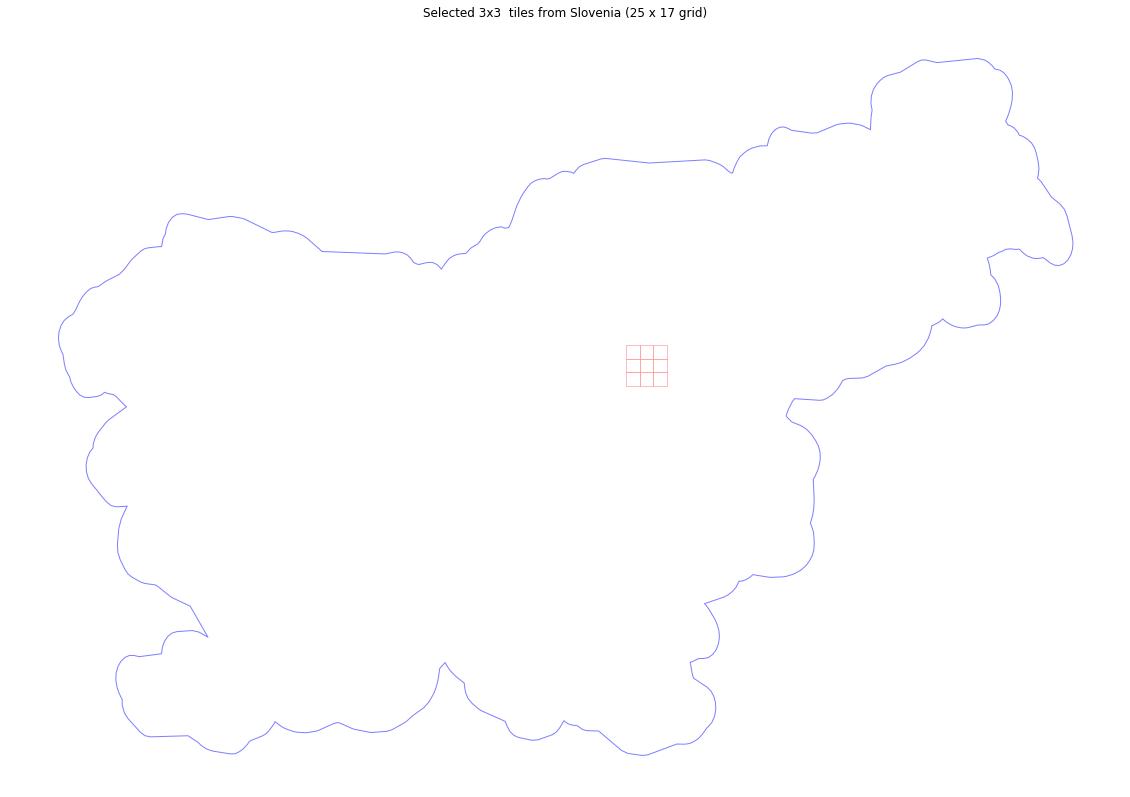

In [301]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3  tiles from Slovenia (25 x 17 grid)');
plt.axis('off')

In [302]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
    
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch


class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndi = (band_a - band_b) / (band_a  + band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])
        
        return eopatch
    
class Addedges(EOTask):   
   
    def __init__(self, band_a):
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        
    def execute(self, eopatch):
        eopatch2 = eopatch.data['NDVI']
        band_a = eopatch2
        band_a = np.swapaxes(band_a,0,2)
        band_a = np.swapaxes(band_a,0,1)
        edge_image = hypedge1(band_a,1,1)
        edge_image=np.sum(edge_image,axis=2)
        edge_image=edge_image<0.6
        edge_image2=edge_image.reshape(edge_image.shape[0],edge_image.shape[1],1)
        t = band_a.shape[2]
        for i in range(t):
            eopatch.data['NDVI'][i,:,:,:]=np.multiply(eopatch.data['NDVI'][i,:,:,:],edge_image2)
            
        for i in range(6):
            for j in range(t):
                eopatch.data[self.band_a_fetaure_name][j,:,:,i] = np.multiply(eopatch.data[self.band_a_fetaure_name][j,:,:,i],edge_image)        
      
        return eopatch

    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch
    
class AddedgesGT(EOTask):   

    def __init__(self, band_a):
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        
    def execute(self, eopatch):
        original = eopatch.mask_timeless['LULC']
        added = original +1
        mask = eopatch.data[self.band_a_fetaure_name][0,:,:,0] != 0
        mask = mask.reshape(mask.shape[0],mask.shape[1],1)
        final = added*mask
        eopatch.mask_timeless['LULC']=final
        
        return eopatch


In [303]:
def hypedge1(input_img,window_size,sigma_s):
  window_size=1
  indx=input_img.shape
  eu=np.zeros((indx[0],indx[1],4))
  from scipy import stats
  from scipy import spatial
#  from pyemd import emd_samples
  w_size=window_size
  x,y=np.meshgrid(range(-w_size,w_size+1),range(-w_size,w_size+1))
  domain=np.exp(-(x**2+y**2)/(2*sigma_s**2))
#  domain=np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
  domainh=domain.copy()
  domainh[:,0:window_size]=0
  domainh[:,window_size+1:2*window_size+1]=0
         
  domainv=domain.copy()
  domainv[0:window_size,:]=0
  domainv[window_size+1:2*window_size+1,:]=0
  
  domaind=domain.copy()
  do=np.eye(2*window_size+1)
  domaind=domaind*do
  
  domaindr=domain.copy()
  do=np.eye(2*window_size+1)
  domaindr=domaindr*np.flip(do,axis=0)
  
#  domainn=np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
  
  for i in range(0,indx[0]):
    for j in range(0,indx[1]):
      imin=max(i-window_size,0)
      imax=min(i+window_size,indx[0]-1)
      jmin=max(j-window_size,0)
      jmax=min(j+window_size,indx[1]-1)
     
      Irim=input_img[imin:(imax)+1,jmin:(jmax)+1,0:indx[2]]

      ind=Irim.shape
      Irimre=Irim.reshape(ind[0]*ind[1],ind[2],order='F')
      a=input_img[i,j,:].reshape(ind[2],order='F')
      dist=np.sqrt(np.sum((Irim-input_img[i,j,:])**2,axis=2))
      distr=dist.reshape(dist.shape[0]*dist.shape[1])
      c1=-i+window_size+1
      c2=-j+window_size+1
      
      domh=domainh[imin+c1-1:imax+c1,jmin+c2-1:jmax+c2]#[imin+c1:imax+c1,jmin+c2:jmax+c2]
      domhr=domh.reshape(domh.shape[0]*domh.shape[1])
      
      domv=domainv[imin+c1-1:imax+c1,jmin+c2-1:jmax+c2]#[imin+c1:imax+c1,jmin+c2:jmax+c2]
      domvr=domv.reshape(domv.shape[0]*domv.shape[1])
      
      domd=domaind[imin+c1-1:imax+c1,jmin+c2-1:jmax+c2]#[imin+c1:imax+c1,jmin+c2:jmax+c2]
      domdr=domd.reshape(domd.shape[0]*domd.shape[1])
      
      domdrr=domaindr[imin+c1-1:imax+c1,jmin+c2-1:jmax+c2]#[imin+c1:imax+c1,jmin+c2:jmax+c2]
      domdrv=domdrr.reshape(domdrr.shape[0]*domdrr.shape[1])

#      print dom.shape,dist.shape,i,j
      #print(i,j)
      medh=np.average(distr,weights=domhr)
      medv=np.average(distr,weights=domvr)
      medd=np.average(distr,weights=domdr)
      meddr=np.average(distr,weights=domdrv)
      eu[i,j,:]=np.array([medh,medv,medd,meddr])
  return eu

In [304]:
# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12) 
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover 
# detection is performed in the next step
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C',
    instance_id='7e1a5e31-c228-4940-a66d-c63c41e1a46d',
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.1, # maximum allowed cloud cover of original ESA tiles
)
        
b1 = Addedges('BANDS/0')

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution 
# and the resulting cloud probability map and mask 
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m', 
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )



# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask 
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [305]:
class LULC(Enum):
    EDGES            = (0,  'Edges',            'white')
    
    #FOREST             = (2,  'Forest',             'xkcd:darkgreen')
    #GRASSLAND          = (3,  'Grassland',          'orange')
    #SHRUBLAND          = (4,  'Shrubland',          'xkcd:tan')
    #WATER              = (5,  'Water',              'xkcd:azure')
    #WETLAND            = (6,  'Wetlands',           'xkcd:lightblue')
    #TUNDRA             = (7,  'Tundra',             'xkcd:lavender')
    ARTIFICIAL_SURFACE = (2,  'Artificial Surface', 'crimson')
    CULTIVATED_LAND    = (1,  'Cultivated Land',    'xkcd:lime')
    #BARELAND           = (9,  'Bareland',           'xkcd:beige')
    #SNOW_AND_ICE       = (10, 'Snow and Ice',       'black')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3
        
# example usecase
# LULC.BARELAND.id   # return 9
        
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)

In [306]:
country = gpd.read_file(os.path.join(DATA_FOLDER,'land_cover_subset_small.shp'))
country.crs={'init' :'epsg:32633'}

mask1=country.lulcid==1
country.lulcid=country.lulcid*mask1
mask2=country.lulcid!=1
country.lulcname=country.lulcname[~mask2]
country.lulcname = country.lulcname.replace(np.nan,'artificial surface')

rasterization_task = VectorToRaster(country, (FeatureType.MASK_TIMELESS, 'LULC'),
                                    values_column='lulcid', raster_shape=(FeatureType.MASK, 'IS_VALID'),
                                    raster_dtype=np.uint8)
b2 = AddedgesGT('BANDS/0')

In [307]:
workflow = LinearWorkflow(
    add_data,
    ndvi,
    b1,
    add_clm,
    ndwi,
    norm,
    add_sh_valmask,
    count_val_sh,
    rasterization_task,
    b2,
    save
)

In [308]:
%%time

# Execute the workflow
time_interval = ['2017-01-01', '2017-12-31'] # time interval for the SH request
# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval':time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=2, multiprocess=False)

executor.make_report()

C:\Users\rudra\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rudra\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rudra\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rudra\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rudra\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rudra\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rudra\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rudra\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true

Wall time: 3min 23s


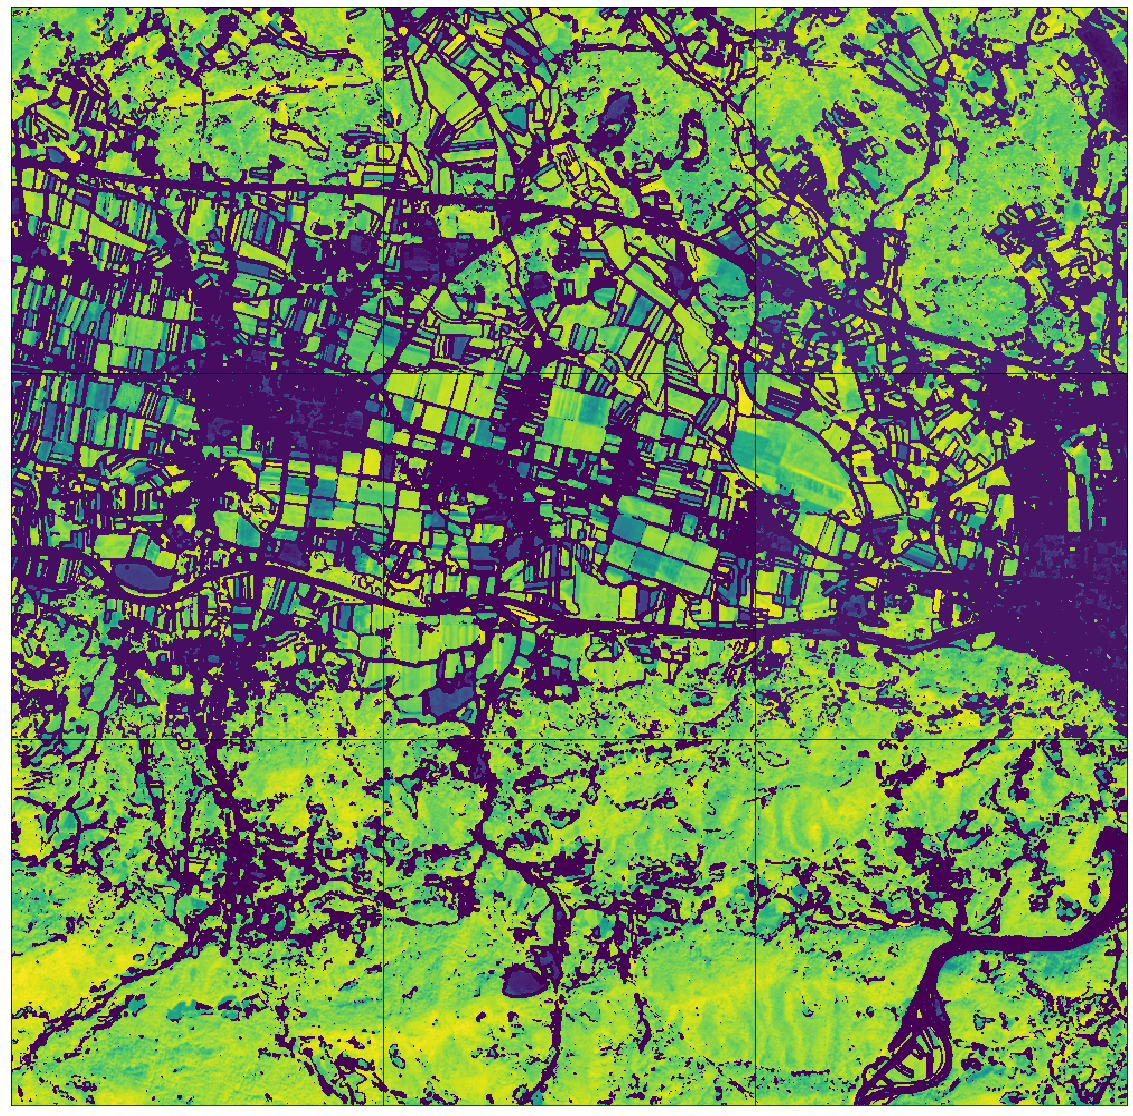

In [310]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
fig = plt.figure(figsize=(20, 20 * aspect_ratio))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((eopatch.data['NDVI'][20,:,:,0]))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

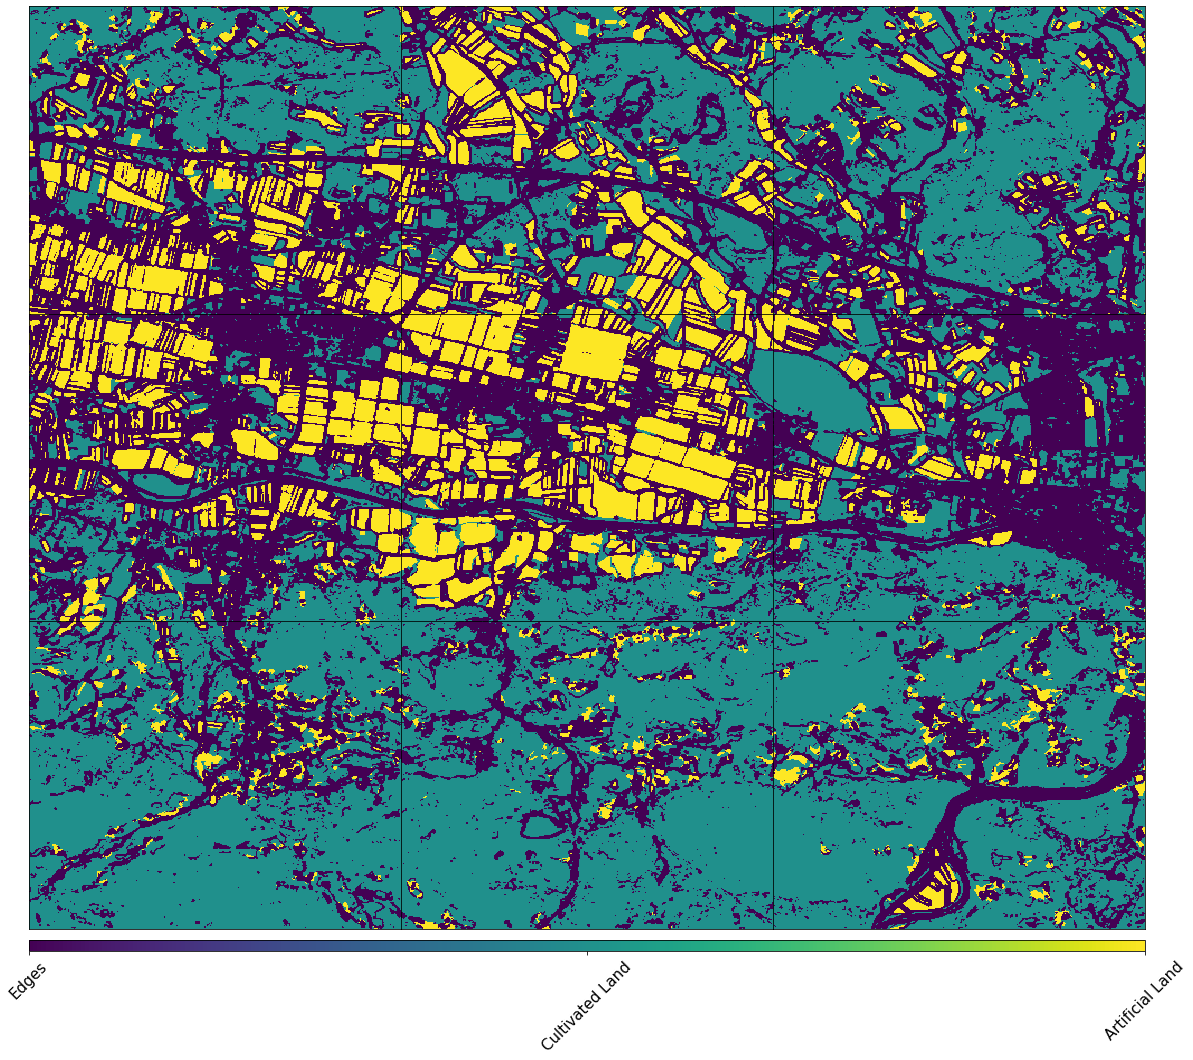

In [360]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)

pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    im = ax.imshow(eopatch.mask_timeless['LULC'].squeeze())
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels(['Edges','Cultivated Land','Artificial Land'], rotation=45, fontsize=15)
plt.show()

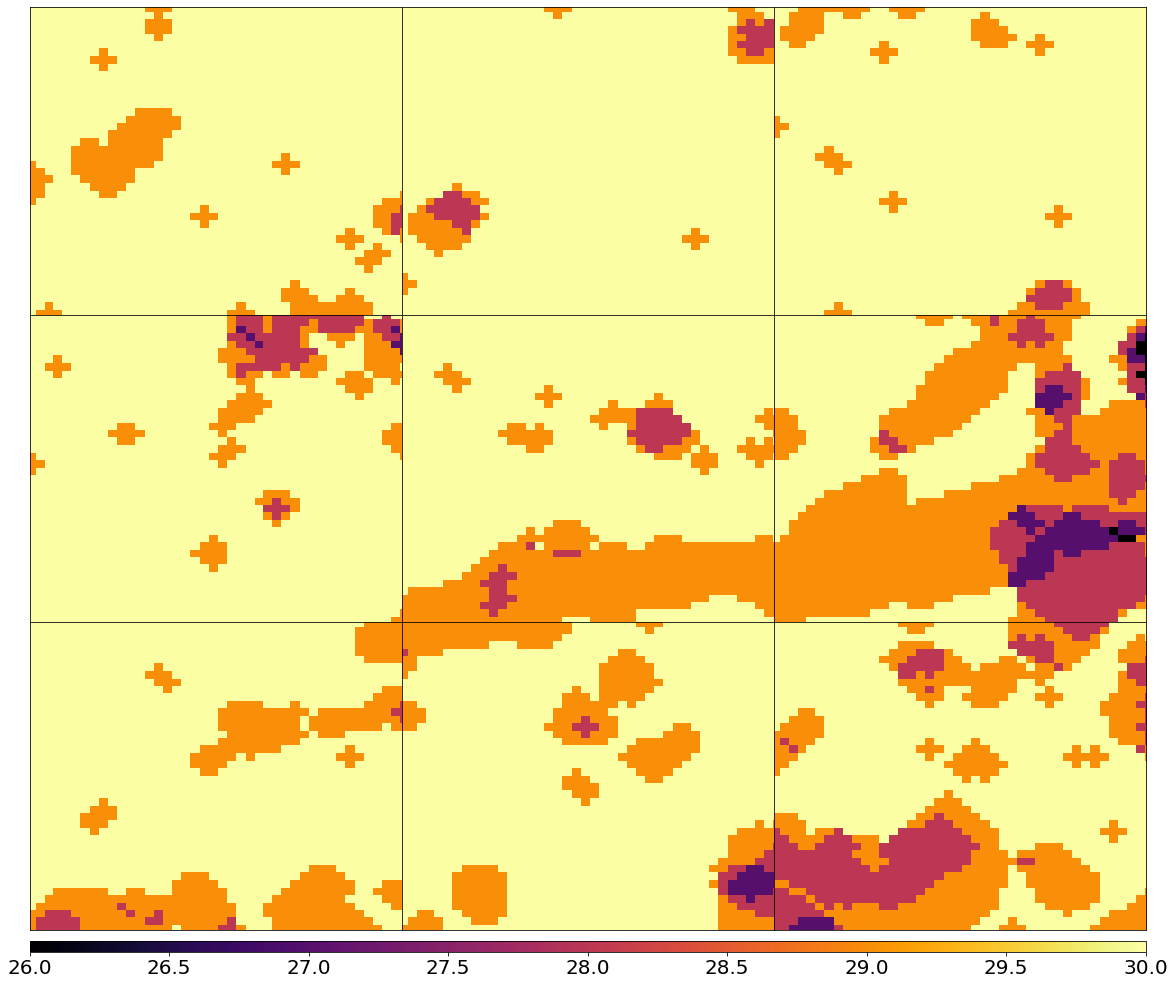

In [312]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

vmin, vmax = None, None
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    data = eopatch.mask_timeless['VALID_COUNT'].squeeze()
    vmin = np.min(data) if vmin is None else (np.min(data) if np.min(data) < vmin else vmin)
    vmax = np.max(data) if vmax is None else (np.max(data) if np.max(data) > vmax else vmax)

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)
    
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    im = ax.imshow(eopatch.mask_timeless['VALID_COUNT'].squeeze(), vmin=vmin, vmax=vmax, cmap=plt.cm.inferno)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

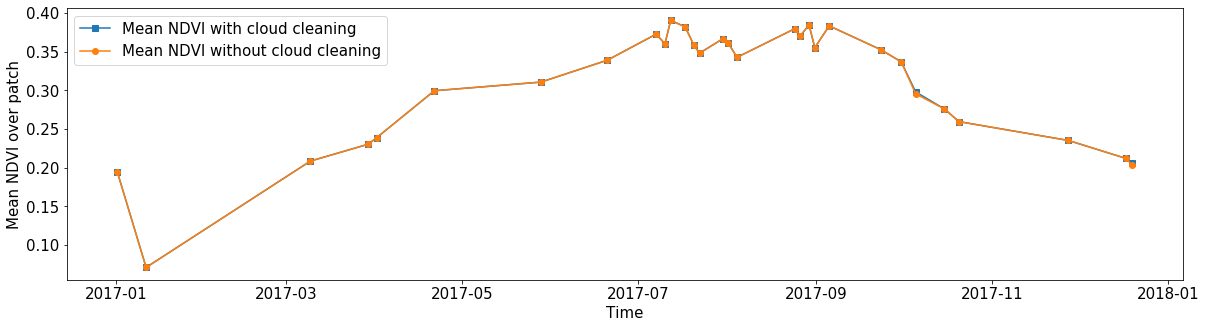

In [313]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

eID = 1
eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, eID), lazy_loading=True)

ndvi = eopatch.data['NDVI'] # ndvi data cube
mask = eopatch.mask['IS_VALID'] # mask of valid pixels
time = np.array(eopatch.timestamp) # x axis
t, w, h, _ = ndvi.shape 

ndvi_clean = ndvi.copy()
ndvi_clean[~mask] = np.nan # set values of invalid pixels to NaN's

# Calculate means, remove NaN's from means
ndvi_mean = np.nanmean(ndvi.reshape(t, w * h).squeeze(), axis=1) 
ndvi_mean_clean = np.nanmean(ndvi_clean.reshape(t, w * h).squeeze(), axis=1)
time_clean = time[~np.isnan(ndvi_mean_clean)]
ndvi_mean_clean = ndvi_mean_clean[~np.isnan(ndvi_mean_clean)]

fig = plt.figure(figsize=(20,5))
plt.plot(time_clean, ndvi_mean_clean, 's-', label = 'Mean NDVI with cloud cleaning')
plt.plot(time, ndvi_mean, 'o-', label='Mean NDVI without cloud cleaning')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Mean NDVI over patch', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc=2, prop={'size': 15});

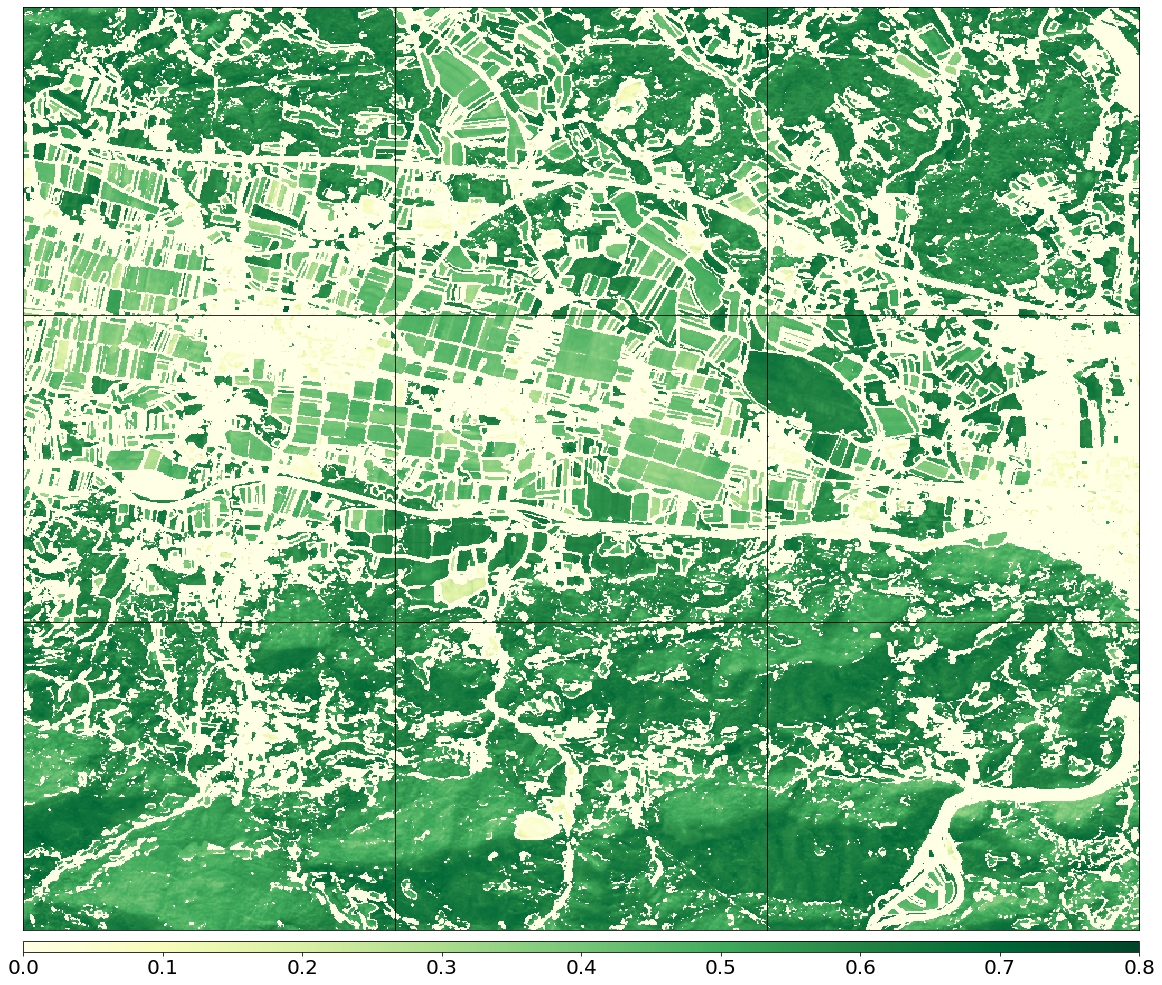

In [315]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)
    
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    ndvi = eopatch.data['NDVI']
    mask = eopatch.mask['IS_VALID']
    ndvi[~mask] = np.nan
    ndvi_mean = np.nanmean(ndvi, axis=0).squeeze()
    im = ax.imshow(ndvi_mean, vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

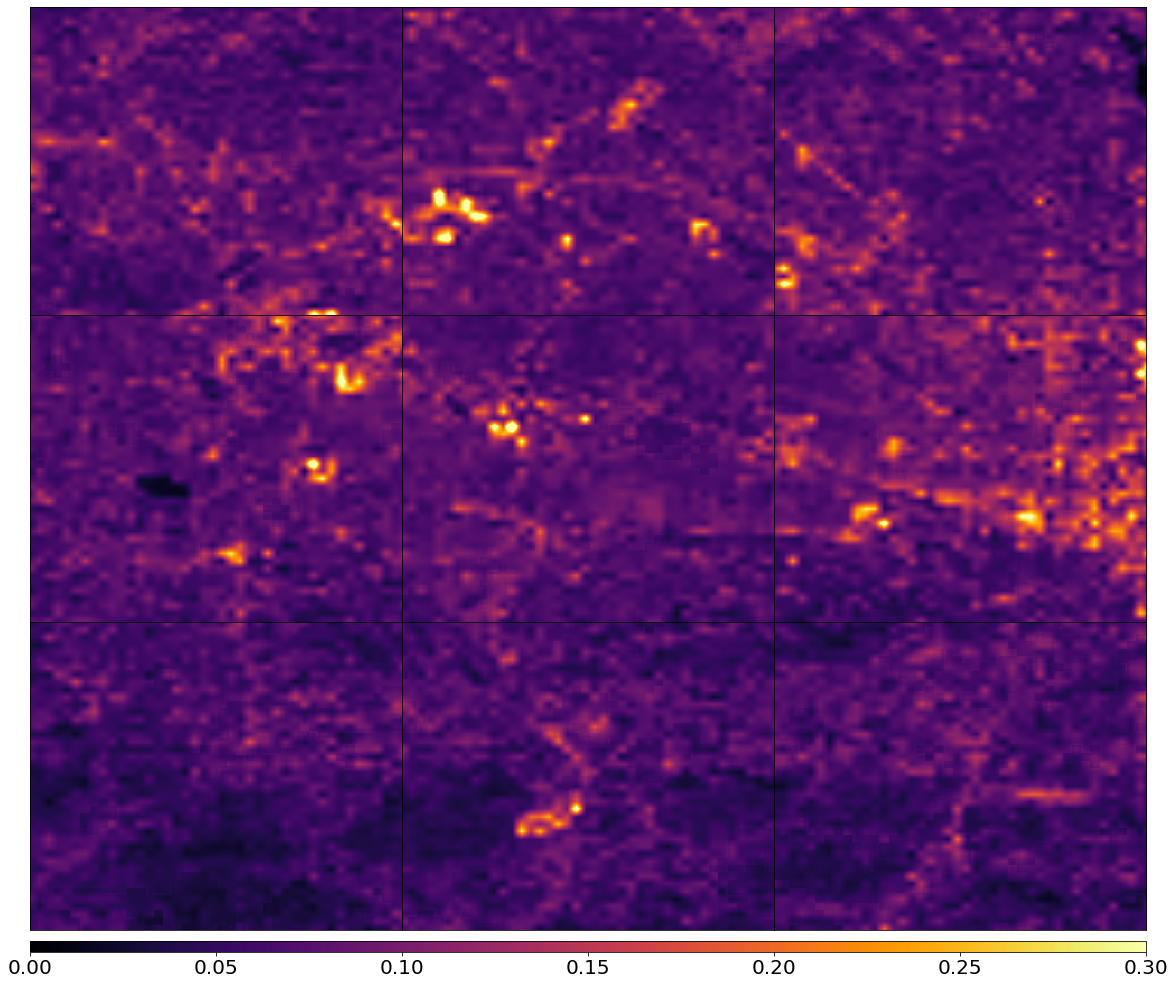

In [316]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)
    
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    clp = eopatch.data['CLP']
    mask = eopatch.mask['IS_VALID']
    clp[~mask] = np.nan
    clp_mean = np.nanmean(clp, axis=0).squeeze()
    im = ax.imshow(clp_mean, vmin=0.0, vmax=0.3, cmap=plt.cm.inferno)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

In [317]:
class ConcatenateData(EOTask):
    """ Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch
    
    
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

In [318]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out)

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES',['NDVI'])

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ('2017-01-01', '2017-12-31', 3)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, 'LULC')], # features to keep
    resample_range=resampled_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)

# TASK FOR EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LULC','LULC_ERODED'), disk_radius=1)

# TASK FOR SPATIAL SAMPLING
# Uniformly sample about pixels from patches
n_samples = int(4e4) if use_smaller_patches else int(1e5) # no. of pixels to sample
ref_labels = list(range(11)) # reference labels to take into account when sampling
spatial_sampling = PointSamplingTask(
    n_samples=n_samples, 
    ref_mask_feature='LULC_ERODED', 
    ref_labels=ref_labels, 
    sample_features=[  # tag fields to sample
        (FeatureType.DATA, 'FEATURES'),
        (FeatureType.MASK_TIMELESS, 'LULC_ERODED')
    ])

path_out_sampled = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'
if not os.path.isdir(path_out_sampled):
    os.makedirs(path_out_sampled)
save = SaveToDisk(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [319]:
# Define the workflow
workflow = LinearWorkflow(
    load,
    concatenate,
    filter_task,
    linear_interp,
    erosion,
    spatial_sampling,
    save
)

In [320]:
execution_args = []
for idx in range(len(patchIDs)):
    execution_args.append({
        load: {'eopatch_folder': 'eopatch_{}'.format(idx)},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=2, multiprocess=False)

executor.make_report()

In [321]:
# load sampled eopatches
eopatches = []
path_out_sampled = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'

for i in range(9):
    eopatches.append(EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, i), lazy_loading=True))    

eopatches = np.array(eopatches)

In [322]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [323]:
# Definition of the train and test patch IDs
train_ID = [0,2,3,4,5,6,7,8] if use_smaller_patches else [0,1,3,4,5,6,7,8]
test_ID = [1] if use_smaller_patches else [2]

# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[train_ID]])
labels_train = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[train_ID]])
features_test = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[test_ID]])
labels_test = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[test_ID]])

# get shape
p1, t, w, h, f = features_train.shape
p2, t, w, h, f = features_test.shape
p = p1 + p2

print(features_train.shape)

# reshape to n x m
features_train = np.moveaxis(features_train, 1, 3).reshape(p1 * w * h, t * f)
labels_train = np.moveaxis(labels_train, 1, 2).reshape(p1 * w * h, 1).squeeze()
features_test = np.moveaxis(features_test, 1, 3).reshape(p2 * w * h, t * f)
labels_test = np.moveaxis(labels_test, 1, 2).reshape(p2 * w * h, 1).squeeze()

# remove points with no reference from training (so we dont train to recognize "no data")
#mask_train = labels_train == 0
#features_train = features_train[~mask_train]
#labels_train = labels_train[~mask_train]
np.nan_to_num(features_train,copy=False)
np.nan_to_num(labels_train,copy=False)
np.nan_to_num(features_test,copy=False)
np.nan_to_num(labels_test,copy=False)
#imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp = imp.fit(features_train)
#features_train_imp=imp.transform(features_train)
#imp = imp.fit(labels_train)
#labels_train_imp=imp.transform(labels_train)
#model = RandomForestClassifier(n_estimators=10)
#m = clf.fit(X_train_imp, Y_train)

#features_train = features_train[~np.isnan(features_train)]
#features_train.reshape(1,-1)
# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
#mask_test = labels_test == 0
#features_test = features_test[~mask_test]
#labels_test = labels_test[~mask_test]

(8, 122, 40000, 1, 1)


array([0, 0, 0, ..., 2, 0, 0], dtype=uint8)

In [324]:
print("shape of training features ",features_train.shape)
print("shape of training labels ",labels_train.shape)
print("shape of test features ",features_test.shape)
print("shape of test labels ",labels_test.shape)

shape of training features  (320000, 122)
shape of training labels  (320000,)
shape of test features  (40000, 122)
shape of test labels  (40000,)


In [325]:
mask_train = labels_train==0
features_train_cheat = features_train[~mask_train,:]
labels_train_cheat = labels_train[~mask_train]
mask_test = labels_test==0
features_test_cheat = features_test[~mask_test,:]
labels_test_cheat = labels_test[~mask_test]

In [326]:
print("shape of training features ",features_train_cheat.shape)
print("shape of training labels ",labels_train_cheat.shape)
print("shape of test features ",features_test_cheat.shape)
print("shape of test labels ",labels_test_cheat.shape)

shape of training features  (143466, 122)
shape of training labels  (143466,)
shape of test features  (15385, 122)
shape of test labels  (15385,)


In [327]:
%%time

# Set up training classes
#labels_train_cheat=labels_train_cheat-1
labels_unique = np.unique(labels_train_cheat)

# Set up the model
#model = lgb.LGBMClassifier(
#    objective='multiclass', 
#    num_class=len(labels_unique), 
#    metric='multi_logloss',
#)

#model = sklearn.pipeline.Pipeline([("scale", StandardScaler()),
#              ("model", RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=2))])

#model= sklearn.make_pipeline(StandardScaler(),
#                   RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=2))
#model = svm.SVC(kernel='linear')
# train the model
#model = MLPClassifier(solver='adam', alpha=1e-5,
#                    hidden_layer_sizes=(10,5,2,2), random_state=1,warm_start=True)
#model = XGBClassifier()
#model = OneVsRestClassifier(CatBoostClassifier(iterations=4000,learning_rate=1,
#                           task_type = "GPU"))

#model = RandomForestClassifier(n_estimators=100,max_depth=10000)
model = CatBoostClassifier(iterations=3000,learning_rate=1,
                           task_type = "GPU")
model.fit(features_train_cheat, labels_train_cheat)

# uncomment to save the model
model_base_name = 'model_SI_LULC_smaller' if use_smaller_patches else 'model_SI_LULC_larger'
joblib.dump(model, './{}.pkl'.format(model_base_name))

0:	learn: 0.1345131	total: 29.2ms	remaining: 1m 27s
1:	learn: 0.1087624	total: 43.1ms	remaining: 1m 4s
2:	learn: 0.0982080	total: 56.7ms	remaining: 56.7s
3:	learn: 0.0934882	total: 69.6ms	remaining: 52.1s
4:	learn: 0.0898839	total: 83.9ms	remaining: 50.2s
5:	learn: 0.0858696	total: 96.6ms	remaining: 48.2s
6:	learn: 0.0817513	total: 110ms	remaining: 47.1s
7:	learn: 0.0771969	total: 124ms	remaining: 46.5s
8:	learn: 0.0747201	total: 139ms	remaining: 46.1s
9:	learn: 0.0726483	total: 153ms	remaining: 45.7s
10:	learn: 0.0699409	total: 169ms	remaining: 45.9s
11:	learn: 0.0676617	total: 183ms	remaining: 45.7s
12:	learn: 0.0656797	total: 199ms	remaining: 45.7s
13:	learn: 0.0638992	total: 215ms	remaining: 45.8s
14:	learn: 0.0623654	total: 231ms	remaining: 45.9s
15:	learn: 0.0614529	total: 244ms	remaining: 45.6s
16:	learn: 0.0604261	total: 257ms	remaining: 45.1s
17:	learn: 0.0589178	total: 272ms	remaining: 45s
18:	learn: 0.0574943	total: 286ms	remaining: 44.9s
19:	learn: 0.0563084	total: 300ms	re

161:	learn: 0.0125530	total: 2.16s	remaining: 37.9s
162:	learn: 0.0123723	total: 2.18s	remaining: 37.9s
163:	learn: 0.0122460	total: 2.19s	remaining: 37.9s
164:	learn: 0.0121461	total: 2.21s	remaining: 37.9s
165:	learn: 0.0120533	total: 2.22s	remaining: 37.9s
166:	learn: 0.0119745	total: 2.23s	remaining: 37.9s
167:	learn: 0.0118931	total: 2.25s	remaining: 37.9s
168:	learn: 0.0117703	total: 2.26s	remaining: 37.9s
169:	learn: 0.0115830	total: 2.27s	remaining: 37.8s
170:	learn: 0.0115023	total: 2.29s	remaining: 37.8s
171:	learn: 0.0114171	total: 2.3s	remaining: 37.8s
172:	learn: 0.0113003	total: 2.31s	remaining: 37.8s
173:	learn: 0.0110809	total: 2.33s	remaining: 37.8s
174:	learn: 0.0110155	total: 2.34s	remaining: 37.7s
175:	learn: 0.0108789	total: 2.35s	remaining: 37.7s
176:	learn: 0.0107750	total: 2.36s	remaining: 37.7s
177:	learn: 0.0107073	total: 2.37s	remaining: 37.6s
178:	learn: 0.0106024	total: 2.39s	remaining: 37.6s
179:	learn: 0.0105578	total: 2.4s	remaining: 37.6s
180:	learn: 0.

320:	learn: 0.0029606	total: 4.21s	remaining: 35.2s
321:	learn: 0.0029001	total: 4.22s	remaining: 35.1s
322:	learn: 0.0028740	total: 4.24s	remaining: 35.1s
323:	learn: 0.0028358	total: 4.25s	remaining: 35.1s
324:	learn: 0.0028125	total: 4.26s	remaining: 35.1s
325:	learn: 0.0027471	total: 4.28s	remaining: 35.1s
326:	learn: 0.0027283	total: 4.29s	remaining: 35.1s
327:	learn: 0.0027009	total: 4.3s	remaining: 35.1s
328:	learn: 0.0026695	total: 4.32s	remaining: 35s
329:	learn: 0.0026414	total: 4.33s	remaining: 35s
330:	learn: 0.0026132	total: 4.34s	remaining: 35s
331:	learn: 0.0026016	total: 4.36s	remaining: 35s
332:	learn: 0.0025898	total: 4.37s	remaining: 35s
333:	learn: 0.0025720	total: 4.38s	remaining: 35s
334:	learn: 0.0025643	total: 4.39s	remaining: 35s
335:	learn: 0.0025447	total: 4.41s	remaining: 34.9s
336:	learn: 0.0025317	total: 4.42s	remaining: 34.9s
337:	learn: 0.0025131	total: 4.43s	remaining: 34.9s
338:	learn: 0.0024955	total: 4.45s	remaining: 34.9s
339:	learn: 0.0024863	total

479:	learn: 0.0009847	total: 6.25s	remaining: 32.8s
480:	learn: 0.0009770	total: 6.26s	remaining: 32.8s
481:	learn: 0.0009693	total: 6.27s	remaining: 32.8s
482:	learn: 0.0009636	total: 6.29s	remaining: 32.8s
483:	learn: 0.0009606	total: 6.3s	remaining: 32.7s
484:	learn: 0.0009528	total: 6.31s	remaining: 32.7s
485:	learn: 0.0009509	total: 6.32s	remaining: 32.7s
486:	learn: 0.0009432	total: 6.33s	remaining: 32.7s
487:	learn: 0.0009395	total: 6.34s	remaining: 32.7s
488:	learn: 0.0009355	total: 6.36s	remaining: 32.6s
489:	learn: 0.0009323	total: 6.37s	remaining: 32.6s
490:	learn: 0.0009277	total: 6.38s	remaining: 32.6s
491:	learn: 0.0009239	total: 6.39s	remaining: 32.6s
492:	learn: 0.0009206	total: 6.4s	remaining: 32.6s
493:	learn: 0.0009157	total: 6.42s	remaining: 32.5s
494:	learn: 0.0009127	total: 6.43s	remaining: 32.5s
495:	learn: 0.0009099	total: 6.44s	remaining: 32.5s
496:	learn: 0.0009032	total: 6.46s	remaining: 32.5s
497:	learn: 0.0008977	total: 6.47s	remaining: 32.5s
498:	learn: 0.

638:	learn: 0.0004791	total: 8.19s	remaining: 30.3s
639:	learn: 0.0004775	total: 8.21s	remaining: 30.3s
640:	learn: 0.0004768	total: 8.22s	remaining: 30.2s
641:	learn: 0.0004755	total: 8.23s	remaining: 30.2s
642:	learn: 0.0004748	total: 8.24s	remaining: 30.2s
643:	learn: 0.0004737	total: 8.25s	remaining: 30.2s
644:	learn: 0.0004727	total: 8.27s	remaining: 30.2s
645:	learn: 0.0004702	total: 8.28s	remaining: 30.2s
646:	learn: 0.0004682	total: 8.29s	remaining: 30.2s
647:	learn: 0.0004667	total: 8.3s	remaining: 30.1s
648:	learn: 0.0004654	total: 8.32s	remaining: 30.1s
649:	learn: 0.0004632	total: 8.33s	remaining: 30.1s
650:	learn: 0.0004623	total: 8.34s	remaining: 30.1s
651:	learn: 0.0004609	total: 8.36s	remaining: 30.1s
652:	learn: 0.0004598	total: 8.37s	remaining: 30.1s
653:	learn: 0.0004573	total: 8.38s	remaining: 30.1s
654:	learn: 0.0004559	total: 8.39s	remaining: 30s
655:	learn: 0.0004553	total: 8.4s	remaining: 30s
656:	learn: 0.0004541	total: 8.42s	remaining: 30s
657:	learn: 0.000451

797:	learn: 0.0002829	total: 10.1s	remaining: 28s
798:	learn: 0.0002824	total: 10.1s	remaining: 27.9s
799:	learn: 0.0002811	total: 10.2s	remaining: 27.9s
800:	learn: 0.0002806	total: 10.2s	remaining: 27.9s
801:	learn: 0.0002799	total: 10.2s	remaining: 27.9s
802:	learn: 0.0002795	total: 10.2s	remaining: 27.9s
803:	learn: 0.0002788	total: 10.2s	remaining: 27.9s
804:	learn: 0.0002785	total: 10.2s	remaining: 27.9s
805:	learn: 0.0002780	total: 10.2s	remaining: 27.8s
806:	learn: 0.0002776	total: 10.2s	remaining: 27.8s
807:	learn: 0.0002769	total: 10.3s	remaining: 27.8s
808:	learn: 0.0002760	total: 10.3s	remaining: 27.8s
809:	learn: 0.0002750	total: 10.3s	remaining: 27.8s
810:	learn: 0.0002747	total: 10.3s	remaining: 27.8s
811:	learn: 0.0002740	total: 10.3s	remaining: 27.8s
812:	learn: 0.0002728	total: 10.3s	remaining: 27.7s
813:	learn: 0.0002722	total: 10.3s	remaining: 27.7s
814:	learn: 0.0002716	total: 10.3s	remaining: 27.7s
815:	learn: 0.0002704	total: 10.4s	remaining: 27.7s
816:	learn: 0.

956:	learn: 0.0001861	total: 12.1s	remaining: 25.7s
957:	learn: 0.0001858	total: 12.1s	remaining: 25.7s
958:	learn: 0.0001851	total: 12.1s	remaining: 25.7s
959:	learn: 0.0001845	total: 12.1s	remaining: 25.7s
960:	learn: 0.0001835	total: 12.1s	remaining: 25.7s
961:	learn: 0.0001824	total: 12.1s	remaining: 25.7s
962:	learn: 0.0001817	total: 12.1s	remaining: 25.7s
963:	learn: 0.0001815	total: 12.1s	remaining: 25.6s
964:	learn: 0.0001810	total: 12.1s	remaining: 25.6s
965:	learn: 0.0001807	total: 12.2s	remaining: 25.6s
966:	learn: 0.0001804	total: 12.2s	remaining: 25.6s
967:	learn: 0.0001792	total: 12.2s	remaining: 25.6s
968:	learn: 0.0001787	total: 12.2s	remaining: 25.6s
969:	learn: 0.0001783	total: 12.2s	remaining: 25.5s
970:	learn: 0.0001780	total: 12.2s	remaining: 25.5s
971:	learn: 0.0001775	total: 12.2s	remaining: 25.5s
972:	learn: 0.0001766	total: 12.2s	remaining: 25.5s
973:	learn: 0.0001762	total: 12.3s	remaining: 25.5s
974:	learn: 0.0001757	total: 12.3s	remaining: 25.5s
975:	learn: 

1113:	learn: 0.0001287	total: 13.9s	remaining: 23.6s
1114:	learn: 0.0001285	total: 13.9s	remaining: 23.6s
1115:	learn: 0.0001284	total: 14s	remaining: 23.6s
1116:	learn: 0.0001283	total: 14s	remaining: 23.6s
1117:	learn: 0.0001282	total: 14s	remaining: 23.5s
1118:	learn: 0.0001276	total: 14s	remaining: 23.5s
1119:	learn: 0.0001272	total: 14s	remaining: 23.5s
1120:	learn: 0.0001271	total: 14s	remaining: 23.5s
1121:	learn: 0.0001268	total: 14s	remaining: 23.5s
1122:	learn: 0.0001265	total: 14s	remaining: 23.5s
1123:	learn: 0.0001264	total: 14.1s	remaining: 23.5s
1124:	learn: 0.0001261	total: 14.1s	remaining: 23.4s
1125:	learn: 0.0001257	total: 14.1s	remaining: 23.4s
1126:	learn: 0.0001256	total: 14.1s	remaining: 23.4s
1127:	learn: 0.0001254	total: 14.1s	remaining: 23.4s
1128:	learn: 0.0001251	total: 14.1s	remaining: 23.4s
1129:	learn: 0.0001242	total: 14.1s	remaining: 23.4s
1130:	learn: 0.0001241	total: 14.1s	remaining: 23.4s
1131:	learn: 0.0001238	total: 14.2s	remaining: 23.4s
1132:	lea

1269:	learn: 0.0000979	total: 15.8s	remaining: 21.5s
1270:	learn: 0.0000979	total: 15.8s	remaining: 21.5s
1271:	learn: 0.0000978	total: 15.8s	remaining: 21.4s
1272:	learn: 0.0000976	total: 15.8s	remaining: 21.4s
1273:	learn: 0.0000971	total: 15.8s	remaining: 21.4s
1274:	learn: 0.0000970	total: 15.8s	remaining: 21.4s
1275:	learn: 0.0000969	total: 15.8s	remaining: 21.4s
1276:	learn: 0.0000968	total: 15.8s	remaining: 21.4s
1277:	learn: 0.0000966	total: 15.9s	remaining: 21.4s
1278:	learn: 0.0000965	total: 15.9s	remaining: 21.4s
1279:	learn: 0.0000964	total: 15.9s	remaining: 21.3s
1280:	learn: 0.0000960	total: 15.9s	remaining: 21.3s
1281:	learn: 0.0000959	total: 15.9s	remaining: 21.3s
1282:	learn: 0.0000956	total: 15.9s	remaining: 21.3s
1283:	learn: 0.0000953	total: 15.9s	remaining: 21.3s
1284:	learn: 0.0000953	total: 15.9s	remaining: 21.3s
1285:	learn: 0.0000951	total: 16s	remaining: 21.3s
1286:	learn: 0.0000951	total: 16s	remaining: 21.3s
1287:	learn: 0.0000950	total: 16s	remaining: 21.2s

1425:	learn: 0.0000774	total: 17.6s	remaining: 19.4s
1426:	learn: 0.0000773	total: 17.6s	remaining: 19.4s
1427:	learn: 0.0000772	total: 17.6s	remaining: 19.4s
1428:	learn: 0.0000771	total: 17.6s	remaining: 19.4s
1429:	learn: 0.0000770	total: 17.7s	remaining: 19.4s
1430:	learn: 0.0000769	total: 17.7s	remaining: 19.4s
1431:	learn: 0.0000768	total: 17.7s	remaining: 19.4s
1432:	learn: 0.0000768	total: 17.7s	remaining: 19.4s
1433:	learn: 0.0000767	total: 17.7s	remaining: 19.3s
1434:	learn: 0.0000766	total: 17.7s	remaining: 19.3s
1435:	learn: 0.0000765	total: 17.7s	remaining: 19.3s
1436:	learn: 0.0000764	total: 17.7s	remaining: 19.3s
1437:	learn: 0.0000762	total: 17.8s	remaining: 19.3s
1438:	learn: 0.0000760	total: 17.8s	remaining: 19.3s
1439:	learn: 0.0000757	total: 17.8s	remaining: 19.3s
1440:	learn: 0.0000757	total: 17.8s	remaining: 19.2s
1441:	learn: 0.0000756	total: 17.8s	remaining: 19.2s
1442:	learn: 0.0000755	total: 17.8s	remaining: 19.2s
1443:	learn: 0.0000754	total: 17.9s	remaining:

1581:	learn: 0.0000631	total: 19.5s	remaining: 17.5s
1582:	learn: 0.0000631	total: 19.6s	remaining: 17.5s
1583:	learn: 0.0000631	total: 19.6s	remaining: 17.5s
1584:	learn: 0.0000630	total: 19.6s	remaining: 17.5s
1585:	learn: 0.0000630	total: 19.6s	remaining: 17.5s
1586:	learn: 0.0000629	total: 19.6s	remaining: 17.5s
1587:	learn: 0.0000628	total: 19.6s	remaining: 17.4s
1588:	learn: 0.0000628	total: 19.6s	remaining: 17.4s
1589:	learn: 0.0000628	total: 19.6s	remaining: 17.4s
1590:	learn: 0.0000627	total: 19.7s	remaining: 17.4s
1591:	learn: 0.0000625	total: 19.7s	remaining: 17.4s
1592:	learn: 0.0000625	total: 19.7s	remaining: 17.4s
1593:	learn: 0.0000624	total: 19.7s	remaining: 17.4s
1594:	learn: 0.0000623	total: 19.7s	remaining: 17.4s
1595:	learn: 0.0000622	total: 19.7s	remaining: 17.3s
1596:	learn: 0.0000621	total: 19.7s	remaining: 17.3s
1597:	learn: 0.0000621	total: 19.7s	remaining: 17.3s
1598:	learn: 0.0000620	total: 19.8s	remaining: 17.3s
1599:	learn: 0.0000619	total: 19.8s	remaining:

1737:	learn: 0.0000535	total: 21.4s	remaining: 15.5s
1738:	learn: 0.0000534	total: 21.4s	remaining: 15.5s
1739:	learn: 0.0000533	total: 21.4s	remaining: 15.5s
1740:	learn: 0.0000533	total: 21.4s	remaining: 15.5s
1741:	learn: 0.0000532	total: 21.4s	remaining: 15.5s
1742:	learn: 0.0000532	total: 21.5s	remaining: 15.5s
1743:	learn: 0.0000531	total: 21.5s	remaining: 15.5s
1744:	learn: 0.0000530	total: 21.5s	remaining: 15.4s
1745:	learn: 0.0000529	total: 21.5s	remaining: 15.4s
1746:	learn: 0.0000528	total: 21.5s	remaining: 15.4s
1747:	learn: 0.0000528	total: 21.5s	remaining: 15.4s
1748:	learn: 0.0000527	total: 21.5s	remaining: 15.4s
1749:	learn: 0.0000526	total: 21.5s	remaining: 15.4s
1750:	learn: 0.0000526	total: 21.5s	remaining: 15.4s
1751:	learn: 0.0000526	total: 21.6s	remaining: 15.4s
1752:	learn: 0.0000525	total: 21.6s	remaining: 15.3s
1753:	learn: 0.0000525	total: 21.6s	remaining: 15.3s
1754:	learn: 0.0000524	total: 21.6s	remaining: 15.3s
1755:	learn: 0.0000523	total: 21.6s	remaining:

1893:	learn: 0.0000461	total: 23.3s	remaining: 13.6s
1894:	learn: 0.0000461	total: 23.3s	remaining: 13.6s
1895:	learn: 0.0000461	total: 23.3s	remaining: 13.6s
1896:	learn: 0.0000460	total: 23.3s	remaining: 13.6s
1897:	learn: 0.0000460	total: 23.3s	remaining: 13.5s
1898:	learn: 0.0000459	total: 23.3s	remaining: 13.5s
1899:	learn: 0.0000459	total: 23.4s	remaining: 13.5s
1900:	learn: 0.0000459	total: 23.4s	remaining: 13.5s
1901:	learn: 0.0000458	total: 23.4s	remaining: 13.5s
1902:	learn: 0.0000458	total: 23.4s	remaining: 13.5s
1903:	learn: 0.0000457	total: 23.4s	remaining: 13.5s
1904:	learn: 0.0000457	total: 23.4s	remaining: 13.5s
1905:	learn: 0.0000457	total: 23.4s	remaining: 13.4s
1906:	learn: 0.0000457	total: 23.4s	remaining: 13.4s
1907:	learn: 0.0000457	total: 23.4s	remaining: 13.4s
1908:	learn: 0.0000456	total: 23.5s	remaining: 13.4s
1909:	learn: 0.0000456	total: 23.5s	remaining: 13.4s
1910:	learn: 0.0000456	total: 23.5s	remaining: 13.4s
1911:	learn: 0.0000456	total: 23.5s	remaining:

2049:	learn: 0.0000406	total: 25.1s	remaining: 11.6s
2050:	learn: 0.0000406	total: 25.1s	remaining: 11.6s
2051:	learn: 0.0000406	total: 25.2s	remaining: 11.6s
2052:	learn: 0.0000405	total: 25.2s	remaining: 11.6s
2053:	learn: 0.0000405	total: 25.2s	remaining: 11.6s
2054:	learn: 0.0000404	total: 25.2s	remaining: 11.6s
2055:	learn: 0.0000404	total: 25.2s	remaining: 11.6s
2056:	learn: 0.0000403	total: 25.2s	remaining: 11.6s
2057:	learn: 0.0000403	total: 25.2s	remaining: 11.5s
2058:	learn: 0.0000402	total: 25.2s	remaining: 11.5s
2059:	learn: 0.0000402	total: 25.2s	remaining: 11.5s
2060:	learn: 0.0000401	total: 25.3s	remaining: 11.5s
2061:	learn: 0.0000401	total: 25.3s	remaining: 11.5s
2062:	learn: 0.0000401	total: 25.3s	remaining: 11.5s
2063:	learn: 0.0000401	total: 25.3s	remaining: 11.5s
2064:	learn: 0.0000401	total: 25.3s	remaining: 11.5s
2065:	learn: 0.0000401	total: 25.3s	remaining: 11.4s
2066:	learn: 0.0000400	total: 25.3s	remaining: 11.4s
2067:	learn: 0.0000400	total: 25.3s	remaining:

2205:	learn: 0.0000360	total: 27s	remaining: 9.71s
2206:	learn: 0.0000360	total: 27s	remaining: 9.7s
2207:	learn: 0.0000359	total: 27s	remaining: 9.69s
2208:	learn: 0.0000359	total: 27s	remaining: 9.68s
2209:	learn: 0.0000359	total: 27s	remaining: 9.66s
2210:	learn: 0.0000358	total: 27.1s	remaining: 9.65s
2211:	learn: 0.0000358	total: 27.1s	remaining: 9.64s
2212:	learn: 0.0000358	total: 27.1s	remaining: 9.63s
2213:	learn: 0.0000358	total: 27.1s	remaining: 9.62s
2214:	learn: 0.0000357	total: 27.1s	remaining: 9.6s
2215:	learn: 0.0000357	total: 27.1s	remaining: 9.59s
2216:	learn: 0.0000357	total: 27.1s	remaining: 9.58s
2217:	learn: 0.0000357	total: 27.1s	remaining: 9.57s
2218:	learn: 0.0000356	total: 27.1s	remaining: 9.55s
2219:	learn: 0.0000356	total: 27.2s	remaining: 9.54s
2220:	learn: 0.0000356	total: 27.2s	remaining: 9.53s
2221:	learn: 0.0000356	total: 27.2s	remaining: 9.52s
2222:	learn: 0.0000355	total: 27.2s	remaining: 9.51s
2223:	learn: 0.0000355	total: 27.2s	remaining: 9.49s
2224:

2361:	learn: 0.0000325	total: 28.9s	remaining: 7.8s
2362:	learn: 0.0000325	total: 28.9s	remaining: 7.79s
2363:	learn: 0.0000325	total: 28.9s	remaining: 7.78s
2364:	learn: 0.0000325	total: 28.9s	remaining: 7.77s
2365:	learn: 0.0000325	total: 28.9s	remaining: 7.75s
2366:	learn: 0.0000324	total: 29s	remaining: 7.74s
2367:	learn: 0.0000324	total: 29s	remaining: 7.73s
2368:	learn: 0.0000324	total: 29s	remaining: 7.72s
2369:	learn: 0.0000324	total: 29s	remaining: 7.71s
2370:	learn: 0.0000324	total: 29s	remaining: 7.69s
2371:	learn: 0.0000324	total: 29s	remaining: 7.68s
2372:	learn: 0.0000324	total: 29s	remaining: 7.67s
2373:	learn: 0.0000324	total: 29s	remaining: 7.66s
2374:	learn: 0.0000324	total: 29.1s	remaining: 7.64s
2375:	learn: 0.0000324	total: 29.1s	remaining: 7.63s
2376:	learn: 0.0000323	total: 29.1s	remaining: 7.62s
2377:	learn: 0.0000323	total: 29.1s	remaining: 7.61s
2378:	learn: 0.0000323	total: 29.1s	remaining: 7.59s
2379:	learn: 0.0000322	total: 29.1s	remaining: 7.58s
2380:	lear

2517:	learn: 0.0000298	total: 30.8s	remaining: 5.89s
2518:	learn: 0.0000298	total: 30.8s	remaining: 5.88s
2519:	learn: 0.0000297	total: 30.8s	remaining: 5.86s
2520:	learn: 0.0000297	total: 30.8s	remaining: 5.85s
2521:	learn: 0.0000297	total: 30.8s	remaining: 5.84s
2522:	learn: 0.0000297	total: 30.8s	remaining: 5.83s
2523:	learn: 0.0000297	total: 30.8s	remaining: 5.81s
2524:	learn: 0.0000296	total: 30.8s	remaining: 5.8s
2525:	learn: 0.0000296	total: 30.9s	remaining: 5.79s
2526:	learn: 0.0000296	total: 30.9s	remaining: 5.78s
2527:	learn: 0.0000296	total: 30.9s	remaining: 5.77s
2528:	learn: 0.0000296	total: 30.9s	remaining: 5.75s
2529:	learn: 0.0000296	total: 30.9s	remaining: 5.74s
2530:	learn: 0.0000295	total: 30.9s	remaining: 5.73s
2531:	learn: 0.0000295	total: 30.9s	remaining: 5.72s
2532:	learn: 0.0000295	total: 30.9s	remaining: 5.71s
2533:	learn: 0.0000295	total: 31s	remaining: 5.69s
2534:	learn: 0.0000294	total: 31s	remaining: 5.68s
2535:	learn: 0.0000294	total: 31s	remaining: 5.67s


2673:	learn: 0.0000272	total: 32.6s	remaining: 3.98s
2674:	learn: 0.0000271	total: 32.6s	remaining: 3.96s
2675:	learn: 0.0000271	total: 32.6s	remaining: 3.95s
2676:	learn: 0.0000271	total: 32.7s	remaining: 3.94s
2677:	learn: 0.0000271	total: 32.7s	remaining: 3.93s
2678:	learn: 0.0000271	total: 32.7s	remaining: 3.92s
2679:	learn: 0.0000271	total: 32.7s	remaining: 3.9s
2680:	learn: 0.0000271	total: 32.7s	remaining: 3.89s
2681:	learn: 0.0000270	total: 32.7s	remaining: 3.88s
2682:	learn: 0.0000270	total: 32.7s	remaining: 3.87s
2683:	learn: 0.0000270	total: 32.7s	remaining: 3.85s
2684:	learn: 0.0000270	total: 32.8s	remaining: 3.84s
2685:	learn: 0.0000270	total: 32.8s	remaining: 3.83s
2686:	learn: 0.0000270	total: 32.8s	remaining: 3.82s
2687:	learn: 0.0000270	total: 32.8s	remaining: 3.81s
2688:	learn: 0.0000269	total: 32.8s	remaining: 3.79s
2689:	learn: 0.0000269	total: 32.8s	remaining: 3.78s
2690:	learn: 0.0000269	total: 32.8s	remaining: 3.77s
2691:	learn: 0.0000269	total: 32.8s	remaining: 

2829:	learn: 0.0000252	total: 34.5s	remaining: 2.07s
2830:	learn: 0.0000252	total: 34.6s	remaining: 2.06s
2831:	learn: 0.0000252	total: 34.6s	remaining: 2.05s
2832:	learn: 0.0000251	total: 34.6s	remaining: 2.04s
2833:	learn: 0.0000251	total: 34.6s	remaining: 2.03s
2834:	learn: 0.0000251	total: 34.6s	remaining: 2.01s
2835:	learn: 0.0000251	total: 34.6s	remaining: 2s
2836:	learn: 0.0000251	total: 34.6s	remaining: 1.99s
2837:	learn: 0.0000251	total: 34.6s	remaining: 1.98s
2838:	learn: 0.0000251	total: 34.7s	remaining: 1.97s
2839:	learn: 0.0000251	total: 34.7s	remaining: 1.95s
2840:	learn: 0.0000251	total: 34.7s	remaining: 1.94s
2841:	learn: 0.0000251	total: 34.7s	remaining: 1.93s
2842:	learn: 0.0000250	total: 34.7s	remaining: 1.92s
2843:	learn: 0.0000250	total: 34.7s	remaining: 1.9s
2844:	learn: 0.0000250	total: 34.7s	remaining: 1.89s
2845:	learn: 0.0000250	total: 34.7s	remaining: 1.88s
2846:	learn: 0.0000249	total: 34.8s	remaining: 1.87s
2847:	learn: 0.0000249	total: 34.8s	remaining: 1.8

2985:	learn: 0.0000236	total: 36.4s	remaining: 171ms
2986:	learn: 0.0000235	total: 36.5s	remaining: 159ms
2987:	learn: 0.0000235	total: 36.5s	remaining: 146ms
2988:	learn: 0.0000235	total: 36.5s	remaining: 134ms
2989:	learn: 0.0000235	total: 36.5s	remaining: 122ms
2990:	learn: 0.0000235	total: 36.5s	remaining: 110ms
2991:	learn: 0.0000235	total: 36.5s	remaining: 97.6ms
2992:	learn: 0.0000235	total: 36.5s	remaining: 85.4ms
2993:	learn: 0.0000235	total: 36.5s	remaining: 73.2ms
2994:	learn: 0.0000235	total: 36.5s	remaining: 61ms
2995:	learn: 0.0000235	total: 36.6s	remaining: 48.8ms
2996:	learn: 0.0000234	total: 36.6s	remaining: 36.6ms
2997:	learn: 0.0000234	total: 36.6s	remaining: 24.4ms
2998:	learn: 0.0000234	total: 36.6s	remaining: 12.2ms
2999:	learn: 0.0000234	total: 36.6s	remaining: 0us
Wall time: 45 s


In [328]:
# uncomment to load the model and replace with your file, usually just correct the date
model_path = './model_SI_LULC_smaller.pkl' if use_smaller_patches else './model_SI_LULC_larger.pkl'
model = joblib.load(model_path)

# predict the test labels
plabels_test_cheat = model.predict(features_test_cheat)
plabels_test_cheat = plabels_test_cheat+1
plabels_test = plabels_test_cheat

In [329]:
#k=0
#ans2=np.zeros((X[:,0].shape[0],1))
#for i in range(X.shape[0]):
#    if(X[i][0]!=0):
#        ans2[i]=result2[k]
#        k=k+1

#k=0
#plabels_test=np.zeros((labels_test.shape[0]))
#for i in range(features_test.shape[0]):
#    if mask_test[i]!=True:
#        plabels_test[i]=plabels_test_cheat[k]
#        k=k+1

In [330]:
labels_test_cheat.shape

(15385,)

In [331]:
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_test_cheat, plabels_test)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_test_cheat, plabels_test, average='weighted')))

Classification accuracy 95.4%
Classification F1-score 95.3%


In [341]:
class_labels = np.unique(labels_test_cheat)
class_names = ['Non Cultivated Land','Cultivated Land', ]

#print(class_labels)
#print(labels_test_cheat.shape)
#print(plabels_test.shape)

f1_scores = metrics.f1_score(labels_test_cheat, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test_cheat, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test_cheat, plabels_test, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx-1] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * Non Cultivated Land  = 96.5 |  98.2  | 94.9
         * Cultivated Land      = 93.1 |  90.0  | 96.3


In [343]:
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

In [344]:
class_names

['Non Cultivated Land', 'Cultivated Land']

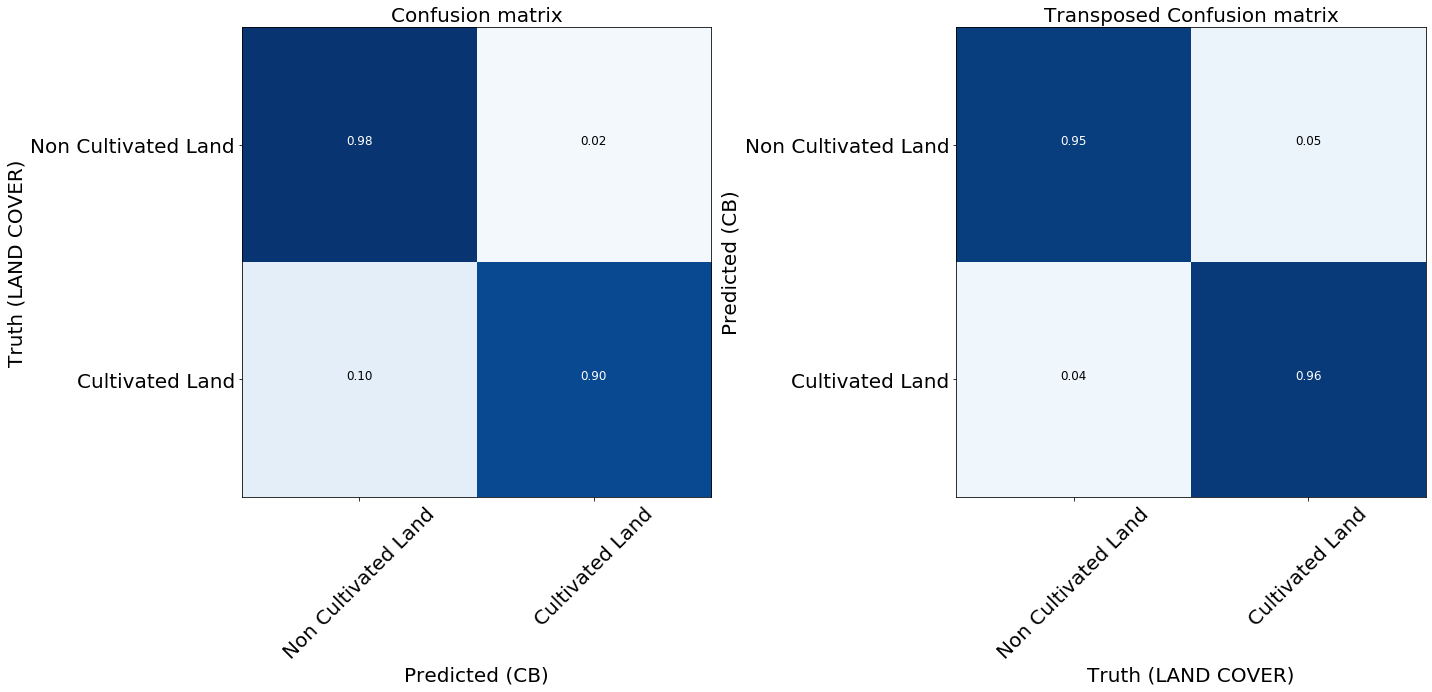

In [345]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
conf_matrix_gbm = metrics.confusion_matrix(labels_test_cheat, plabels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx+1 in class_labels], 
                      normalize=True, 
                      ylabel='Truth (LAND COVER)', 
                      xlabel='Predicted (CB)',
                      title='Confusion matrix');

plt.subplot(1, 2, 2)
conf_matrix_gbm = metrics.confusion_matrix(plabels_test, labels_test_cheat)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx+1 in class_labels], 
                      normalize=True, 
                      xlabel='Truth (LAND COVER)', 
                      ylabel='Predicted (CB)',
                      title='Transposed Confusion matrix');

plt.tight_layout()

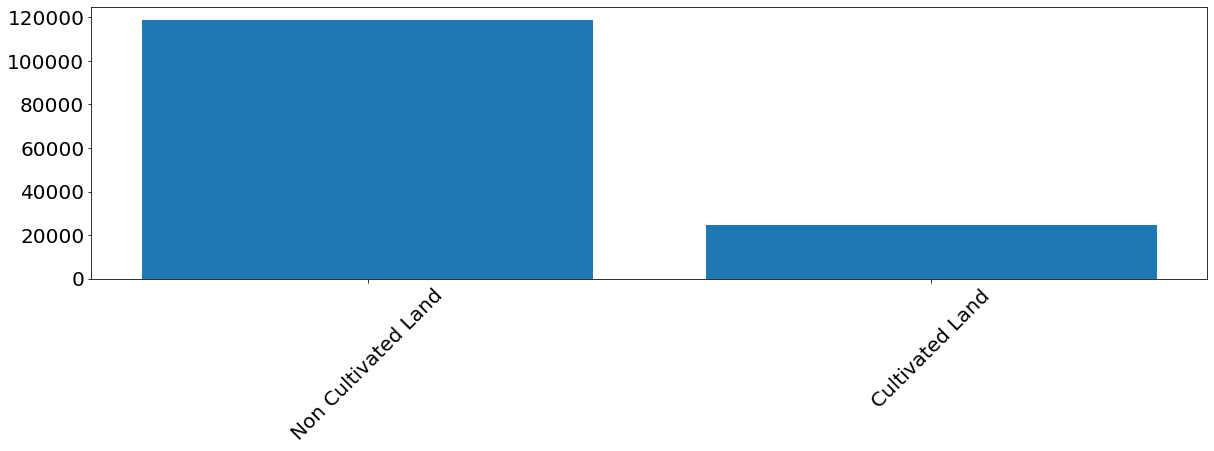

In [346]:
fig = plt.figure(figsize=(20, 5))

label_ids, label_counts = np.unique(labels_train_cheat, return_counts=True)
label_ids = label_ids - 1

plt.bar(range(len(label_ids)), label_counts)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation=45, fontsize=20);
plt.yticks(fontsize=20);

In [347]:
class_labels = np.unique(np.hstack([labels_test_cheat, labels_train_cheat]))
labels_binarized = preprocessing.label_binarize(labels_test_cheat, classes=class_labels)
labels_binarized.shape

(15385, 1)

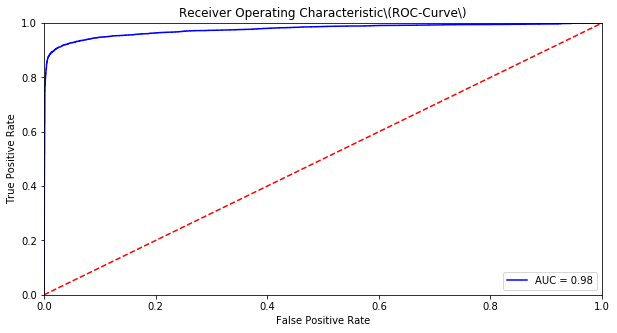

In [348]:
class_labels = np.unique(np.hstack([labels_test_cheat, labels_train_cheat]))
scores_test = model.predict_proba(features_test_cheat)
labels_binarized = preprocessing.label_binarize(labels_test_cheat, classes=class_labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
l=enumerate(class_labels)
# labels_binarized.shape

preds=scores_test[:,1]
fpr, tpr, threshold = metrics.roc_curve(labels_binarized,preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.title('Receiver Operating Characteristic\(ROC-Curve\)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

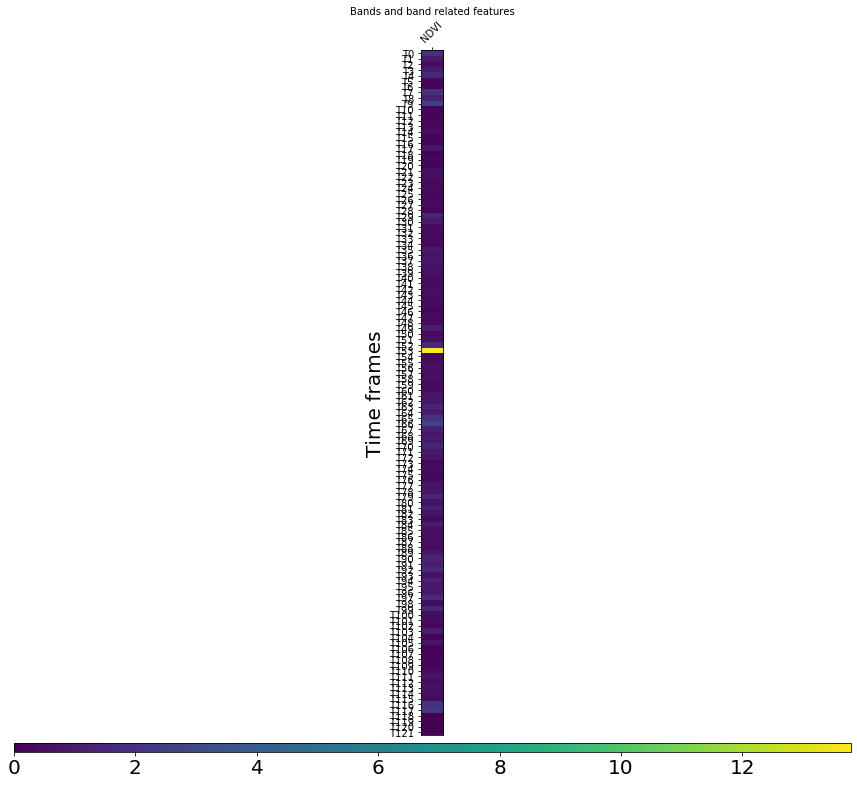

In [349]:
# names of features
fnames = ['NDVI']

# get feature importances and reshape them to dates and features
z = model.feature_importances_.reshape((t, f))

fig = plt.figure(figsize=(15, 15))
ax = plt.gca()

# plot the importances
im = ax.imshow(z, aspect=0.25)
plt.xticks(range(len(fnames)), fnames, rotation=45, fontsize=10)
plt.yticks(range(t), ['T{}'.format(i) for i in range(t)], fontsize=10)
plt.xlabel('Bands and band related features', fontsize=10)
plt.ylabel('Time frames', fontsize=20)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# cax = fig.add_axes([0.82, 0.125, 0.04, 0.755]) 
# plt.colorbar(im, cax=cax)

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=[ax], orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)

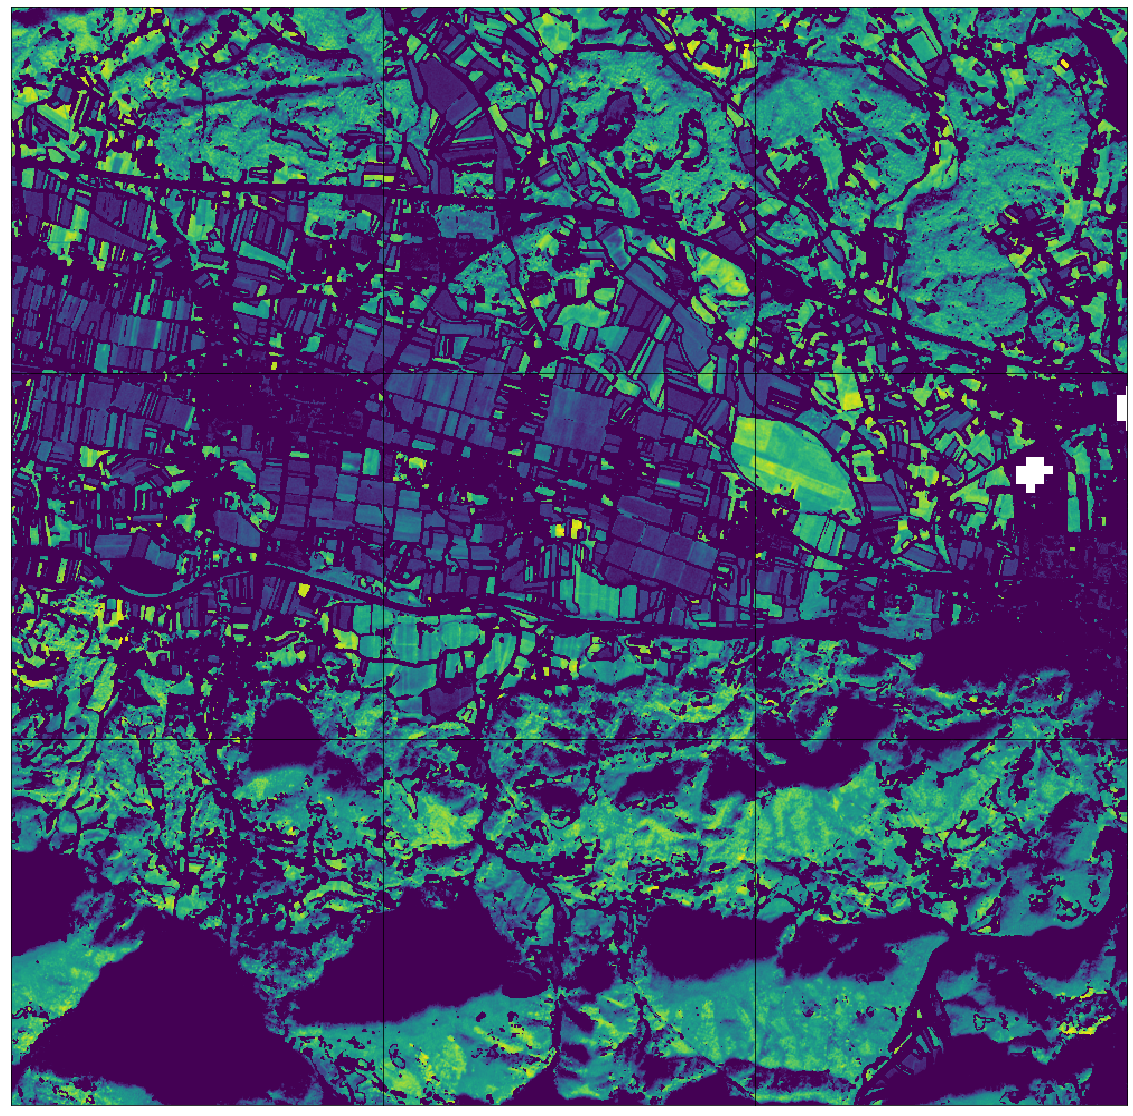

In [350]:
# Draw the RGB image
path_out_sampled = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'
fig = plt.figure(figsize=(20, 20 * aspect_ratio))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, i), lazy_loading=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.clip(eopatch.data['FEATURES'][0,:,:,0], 0, 1))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

In [351]:
#b2_t1 = np.moveaxis(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches]),1, 3)[..., 6, 0].reshape(p * h * w)
#b2_t19 = np.moveaxis(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches]),1, 3)[..., 5, 0].reshape(p * h * w)
ndvi_t1 = np.moveaxis(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches]),1, 3)[..., 6, 0].reshape(p * h * w)
ndvi_t19 = np.moveaxis(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches]),1, 3)[..., 5, 0].reshape(p * h * w)
labels = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches]).reshape(p * h * w * 1)
# remove nans
# mask = np.any([np.isnan(b2_t1), np.isnan(b2_t19), np.isnan(ndvi_t1), np.isnan(ndvi_t19), labels==0], axis=0)
# b2_t1, b2_t19, ndvi_t1, ndvi_t19, labels = [array[~mask] for array in [b2_t1, b2_t19, ndvi_t1, ndvi_t19, labels]]

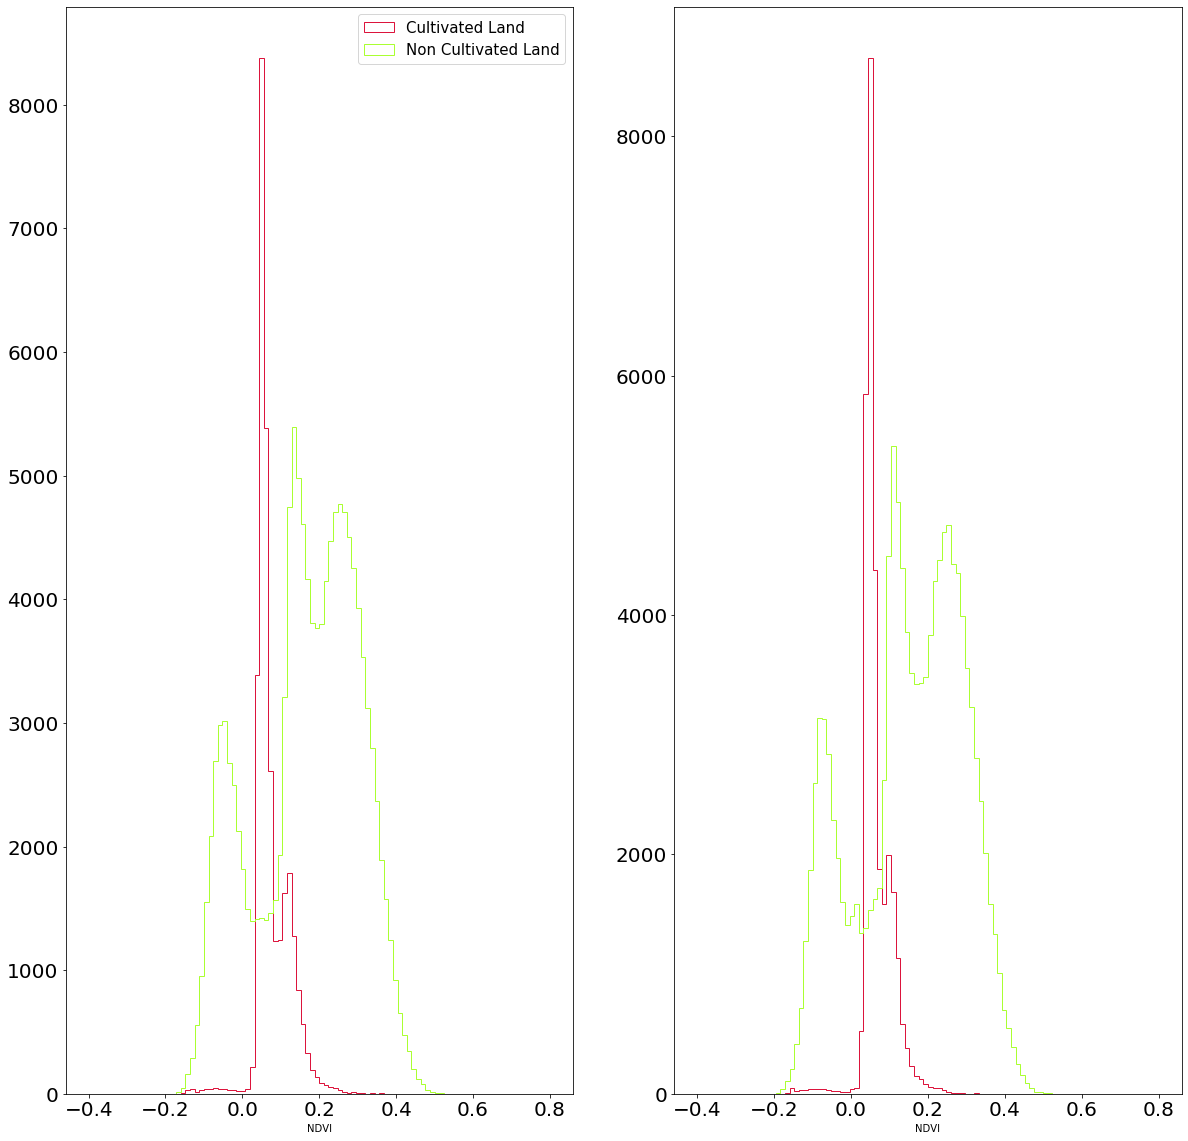

In [352]:
fig = plt.figure(figsize=(20, 20))

plot_labels=[1,2]

plt.subplot(1, 2, 1)
plt.hist([ndvi_t1[labels == i] for i in plot_labels],100,(-0.4, 0.8),histtype='step',color=[plot_colors[i] for i in plot_labels],label=[class_names[i-1] for i in plot_labels]);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('NDVI', fontsize=10)
plt.legend(loc=1, prop={'size': 15})


plt.subplot(1, 2, 2)
plt.hist([ndvi_t19[labels == i] for i in [1,2]],100,(-0.4, 0.8),histtype='step',color=[plot_colors[i] for i in plot_labels]);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('NDVI', fontsize=10);

In [353]:
class PredictPatch(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature, 
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name
        
    def execute(self, eopatch):
        ftrs = eopatch[self.features_feature[0]][self.features_feature[1]]
        
        t, w, h, f = ftrs.shape
        ftrs = np.moveaxis(ftrs, 0, 2).reshape(w * h, t * f)
        mask = ftrs[:,30]==0
        ftrs_cheat = ftrs[~mask,:]
        plabels_cheat = self.model.predict(ftrs_cheat)
        plabels_cheat = plabels_cheat + 1
        
        k=0
        plabels = np.zeros((ftrs.shape[0]))
        for i in range(ftrs.shape[0]):
            if mask[i]!=True:
                plabels[i]=plabels_cheat[k]
                k=k+1
        
        plabels = plabels.reshape(w, h)
        plabels = plabels[..., np.newaxis]
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.predicted_labels_name, plabels)
        
        if self.predicted_scores_name:
            pscores = self.model.predict_proba(ftrs)
            _, d = pscores.shape
            pscores = pscores.reshape(w, h, d)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.predicted_scores_name, pscores)
        
        return eopatch
    
#k=0
#plabels_test=np.zeros((labels_test.shape[0]))
#for i in range(features_test.shape[0]):
#    if mask_test[i]!=True:
#        plabels_test[i]=plabels_test_cheat[k]
#        k=k+1

In [354]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out_sampled)

# TASK FOR PREDICTION
predict = PredictPatch(model, (FeatureType.DATA, 'FEATURES'), 'LBL_GBM', 'SCR_GBM')

# TASK FOR SAVING
save = SaveToDisk(str(path_out_sampled), overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# TASK TO EXPORT TIFF
export_tiff = ExportToTiff((FeatureType.MASK_TIMELESS, 'LBL_GBM'))
tiff_location = './predicted_tiff'
if not os.path.isdir(tiff_location):
    os.makedirs(tiff_location)

workflow = LinearWorkflow(
    load,
    predict,
    export_tiff,
    save
)

In [355]:
# create a list of execution arguments for each patch
execution_args = []
for i in range(len(patchIDs)):
    execution_args.append(
        {
            load: {'eopatch_folder': 'eopatch_{}'.format(i)},
            export_tiff: {'filename': '{}/prediction_eopatch_{}.tiff'.format(tiff_location, i)},
            save: {'eopatch_folder': 'eopatch_{}'.format(i)}
        }
    )

# run the executor on 2 cores
executor = EOExecutor(workflow, execution_args)

# uncomment below save the logs in the current directory and produce a report!
#executor = EOExecutor(workflow, execution_args, save_logs=True)

executor.run(workers=2, multiprocess=False)
# executor.make_report()

In [356]:
%%time
# merge with gdal_merge.py (with compression) using bash command magic
!gdal_merge.py -o predicted_tiff/merged_prediction.tiff -co compress=LZW predicted_tiff/prediction_eopatch_*

No input files selected.
Usage: gdal_merge.py [-o out_filename] [-of out_format] [-co NAME=VALUE]*
                     [-ps pixelsize_x pixelsize_y] [-tap] [-separate] [-q] [-v] [-pct]
                     [-ul_lr ulx uly lrx lry] [-init "value [value...]"]
                     [-n nodata_value] [-a_nodata output_nodata_value]
                     [-ot datatype] [-createonly] input_files
                     [--help-general]

Wall time: 780 ms


In [357]:
#test
eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, 0), lazy_loading=True)
eopatch.data['FEATURES']

array([[[[0.28],
         [0.37],
         [0.37],
         ...,
         [0.05],
         [0.06],
         [0.14]],

        [[0.32],
         [0.43],
         [0.45],
         ...,
         [0.  ],
         [0.08],
         [0.11]],

        [[0.27],
         [0.4 ],
         [0.41],
         ...,
         [0.  ],
         [0.  ],
         [0.1 ]],

        ...,

        [[0.11],
         [0.12],
         [0.  ],
         ...,
         [0.  ],
         [0.  ],
         [0.  ]],

        [[0.1 ],
         [0.09],
         [0.07],
         ...,
         [0.  ],
         [0.  ],
         [0.  ]],

        [[0.08],
         [0.09],
         [0.06],
         ...,
         [0.  ],
         [0.  ],
         [0.  ]]],


       [[[0.25],
         [0.33],
         [0.32],
         ...,
         [0.05],
         [0.06],
         [0.11]],

        [[0.29],
         [0.39],
         [0.39],
         ...,
         [0.  ],
         [0.07],
         [0.09]],

        [[0.26],
         [0.34],
      

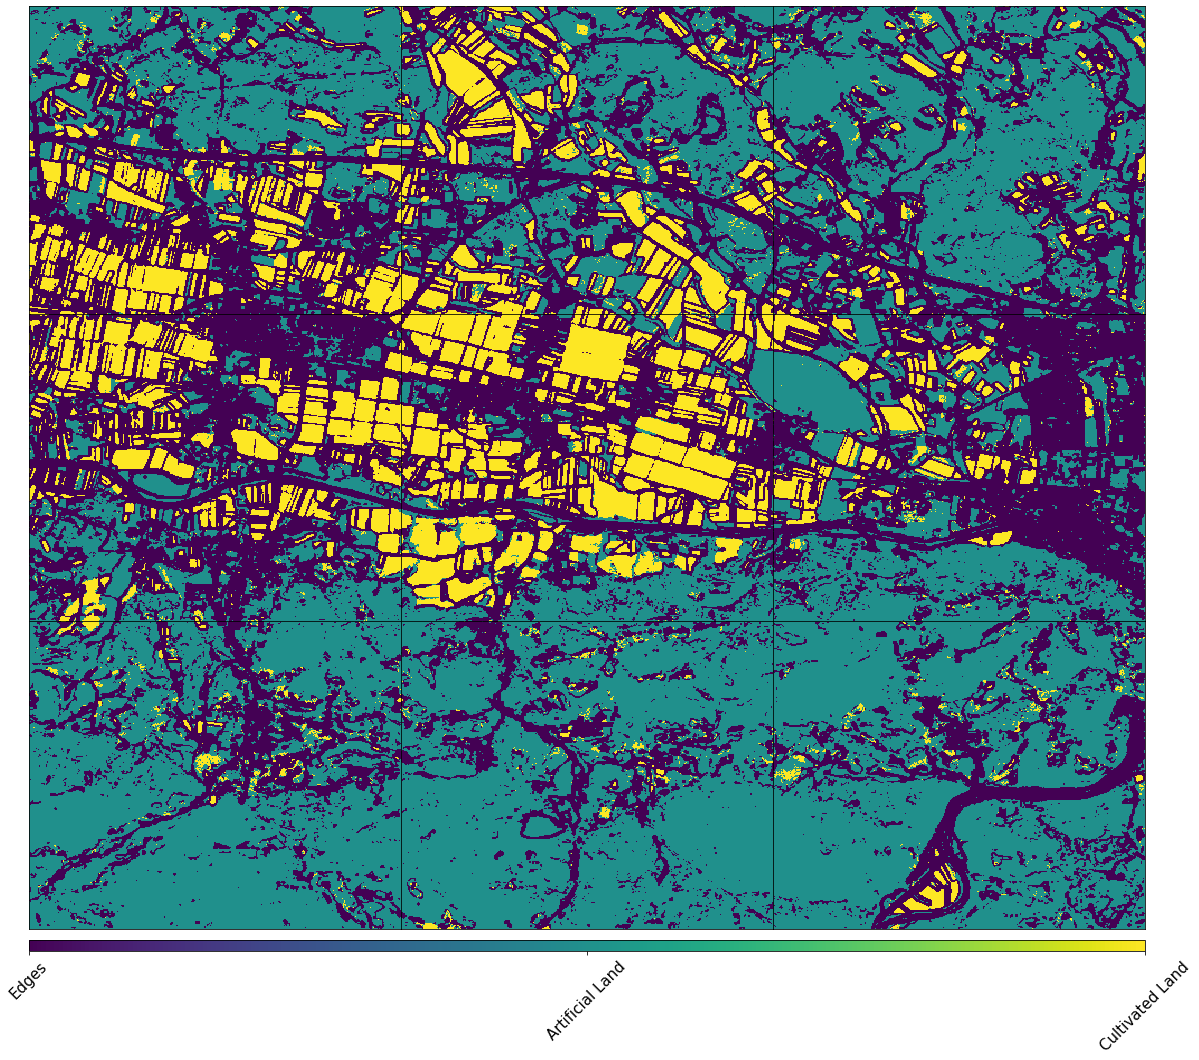

In [361]:
path_out_sampled = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)

pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, i), lazy_loading=True)
    im = ax.imshow(eopatch.mask_timeless['LBL_GBM'].squeeze())
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels(['Edges','Cultivated Land','Artificial Land'], rotation=45, fontsize=15)
plt.show()

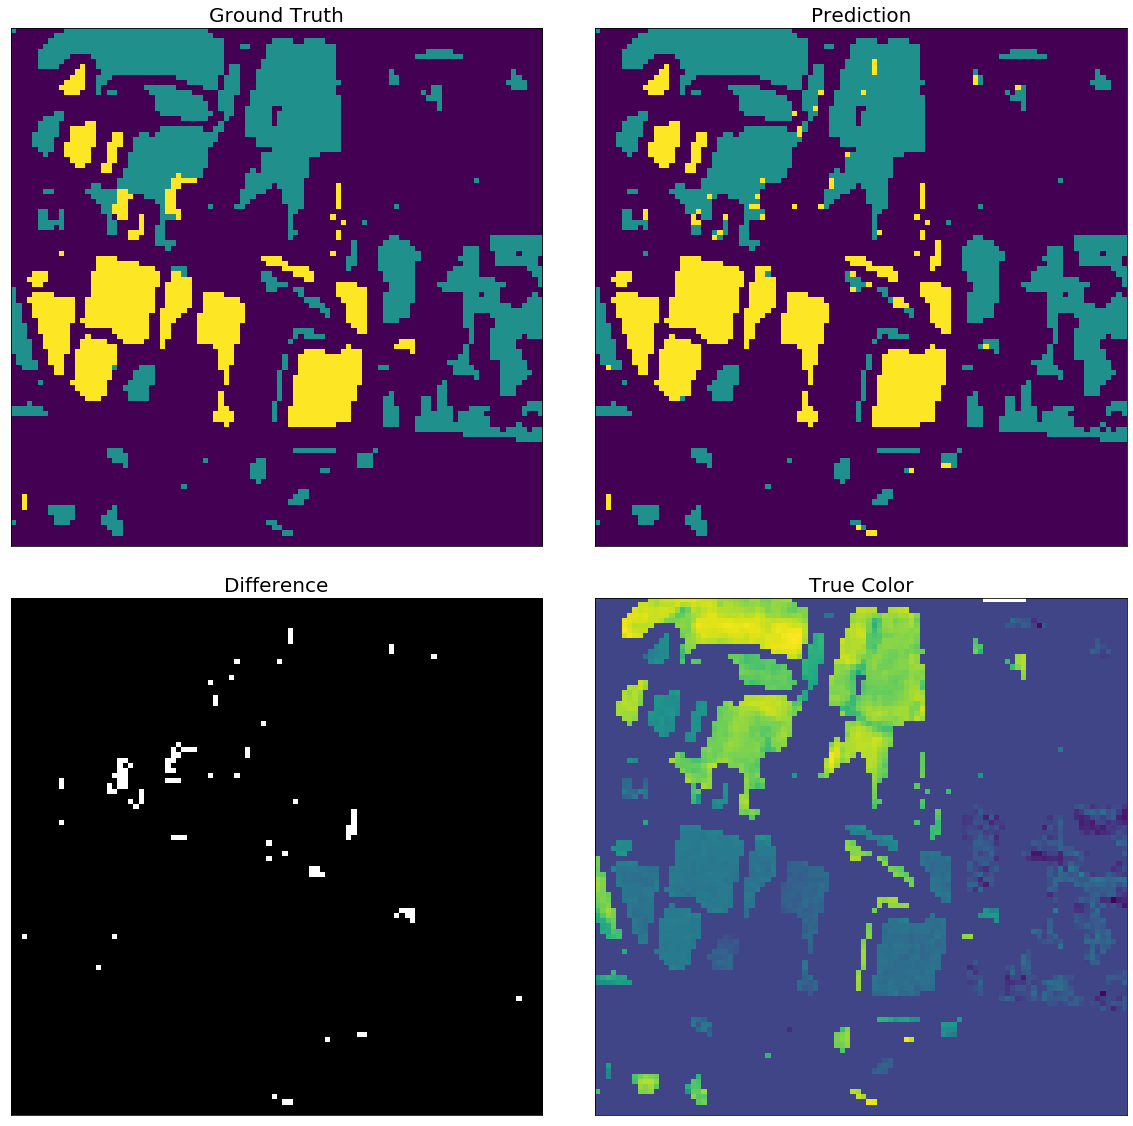

In [362]:
# Draw the Reference map

fig = plt.figure(figsize=(20, 20))

idx = np.random.choice(range(9))
inspect_size = 100

eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, idx), lazy_loading=True)

w, h = eopatch.mask_timeless['LULC'].squeeze().shape

w_min = np.random.choice(range(w - inspect_size))
h_min = np.random.choice(range(h - inspect_size))

ax = plt.subplot(2, 2, 1)
plt.imshow(eopatch.mask_timeless['LULC'].squeeze()[w_min: w_min + inspect_size, h_min : h_min + inspect_size])
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Ground Truth', fontsize=20)

ax = plt.subplot(2, 2, 2)
plt.imshow(eopatch.mask_timeless['LBL_GBM'].squeeze()[w_min: w_min + inspect_size, h_min: h_min + inspect_size])
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Prediction', fontsize=20)

ax = plt.subplot(2, 2, 3)
mask = eopatch.mask_timeless['LBL_GBM'].squeeze() != eopatch.mask_timeless['LULC'].squeeze()
plt.imshow(mask[w_min: w_min + inspect_size, h_min: h_min + inspect_size], cmap='gray')
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('Difference', fontsize=20)

ax = plt.subplot(2, 2, 4)
image = eopatch.data['FEATURES'][0,:,:,0]
plt.imshow(image[w_min: w_min + inspect_size, h_min: h_min + inspect_size])
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('True Color', fontsize=20)

fig.subplots_adjust(wspace=0.1, hspace=0.1)

In [289]:
#h*w

In [290]:
#np.unique(labels)

In [291]:
#class_names

In [296]:
#plot_colors

['white', 'xkcd:lime', 'crimson']

In [293]:
#class_names